In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, gamma, uniform, rv_continuous
from scipy.linalg import cholesky, LinAlgError, eigvalsh, eigh, inv
import dyPolyChord.pypolychord_utils
import dyPolyChord
import time
import sys
import os
import six
import corner
import emcee as em
from math import log10, floor
from IPython.display import display, Math
from tqdm import tqdm
from scipy.special import gamma as gamma_func
from scipy.special import kv
from multiprocessing import Pool


%matplotlib notebook

In [2]:
def round_sig(x, sig=1):
    """
    Rounds a float to the given number of significant
    figures.
    
    Parameters
    -------------
    x    : Float
           Float to be rounded
    sig  : Integer
           Number of sig. figures
    """
    
    i = sig-int(np.floor(np.log10(abs(x))))-1
    return np.around(x, i), i

def rbf(theta,x):
    
    return theta[0]**2 * np.exp(-0.5 * theta[1]**-2 * np.subtract.outer(x,x)**2)

def periodic(theta,x):
    
    return theta[0]**2 * np.exp(-2 * theta[1]**-2 * np.sin(np.pi * np.subtract.outer(x,x) / theta[2])**2)

def local_periodic(theta,x):
    
    return rbf(theta,x) * periodic(theta,x)

def matern(theta, x):
    
    if theta[1] > 18:
        return rbf([theta[0], theta[2]], x)
    else:
        u = np.sqrt(2 * theta[1]) * abs(np.subtract.outer(x,x) / theta[2])
        u[u == 0.0] += np.finfo(float).eps
        K = theta[0] * 2**(1-theta[1]) / gamma_func(theta[1]) * (u)**theta[1] * kv(theta[1], u)

        return K


def GP(kernel, theta, data, mu_prior=[], sigma=[]):
    
    
    # Define test points (XT) and training data (X, y)
    XT, X, y = data
    n = len(X)
    
    # Calculate cov. matrix for join distribution
    K = kernel(10**theta, np.concatenate((X, XT)))
    
    # For non-noisy training data set sigma = 0
    if len(sigma)==0:
        sigma = np.zeros(n)
    if len(mu_prior)==0:
        mu_prior = np.zeros(n)
    
    # Sub-matrices of joint distribution, using cholesky decomp. for inversion
    K_XTX = K[n:,:n]
    K_XX = K[:n,:n]+np.diag(sigma**2)
    ch_K_XX = cholesky(K_XX, lower=True)
    K_XX_inv = inv(ch_K_XX.T) @ inv(ch_K_XX)#inv(K[:n,:n]+np.diag(sigma**2))
    K_XXT = K[:n,n:]
    K_XTXT = K[n:,n:]
    
    # Find conditioned mean function and covariance matrix
    m = K_XTX @ K_XX_inv @ (y-mu_prior)
    K = K_XTXT - K_XTX @ K_XX_inv @ K_XXT
    
    return (m, np.sqrt(np.diag(K)))

def loglikelihood(theta, data, kernel=rbf):
    
    """Data has structure (XT, X, y, yT, sigmaT, sigma)"""
    # Define global variables

    # normalisation
    norm = -0.5*len(data[0])*np.log(2*np.pi) - np.sum(np.log(data[4]))

    # chi-squared
    chisq = np.sum(((data[3]-GP(kernel, theta, data[:3], sigma=data[5])[0])/data[4])**2)

    return norm - 0.5*chisq

def logposterior(theta, data, logprior, kernel=rbf):
    
    lp = logprior(theta)
    
    if not np.isfinite(lp):
        
        return -np.inf
    
    return lp + loglikelihood(theta, data, kernel=kernel)

def rbf_logprior(theta, data):
    
    s, l = theta
    diff = np.diff(data[1])
    p_min = np.log10(2*np.min(diff))
    p_max = np.log10(2*np.max(diff))

    return uniform.logpdf(s, -2, 4) + uniform.logpdf(l, p_min, p_max-p_min)

def local_periodic_logprior(theta, data):
    
    s, l, p = theta
    diff = np.diff(data[1])
    p_max = np.log10(2*np.max(diff))
    p_min = np.log10(2*np.min(diff))
    
    return uniform.logpdf(s, -2, 4) + uniform.logpdf(l, p_min, p_max-p_min) + uniform.logpdf(p, p_min, p_max-p_min)

def matern_logprior(theta, data):
    
    nu, l = theta
    diff = np.diff(data[1])
    p_min = np.log10(2*np.min(diff))
    p_max = np.log10(2*np.max(diff))
    
    return uniform.logpdf(nu, 0, 18) + uniform.logpdf(l, p_min, p_max-p_min)

def rbf_inisamples(Nens, data):
    
    diff = np.diff(data[1])
    p_min = np.log10(2*np.min(diff))
    p_max = np.log10(2*np.max(diff))
    
    return np.vstack((uniform.rvs(-2,4, size=Nens),uniform.rvs(p_min, p_max-p_min, size=Nens))).T

def local_periodic_inisamples(Nens, data):
    
    diff = np.diff(data[1])
    p_max = np.log10(2*np.max(diff))
    p_min = np.log10(2*np.min(diff))
    
    return np.vstack((uniform.rvs(-2,4, size=Nens),
                      uniform.rvs(p_min, p_max-p_min, size=Nens), uniform.rvs(p_min, p_max-p_min, size=Nens))).T

def matern_inisamples(Nens, data):
    
    diff = np.diff(data[1])
    l_gmean = np.sqrt(np.min(diff)*np.max(diff))
    
    uniform_log = uniform_log_gen(name='uniform_log')
    gamma_log = gamma_log_gen(name='gamma_log')
    
    return np.vstack((uniform.rvs(0, 18, size=Nens),gamma.rvs(4.5, l_gmean, size=Nens))).T

def rbf_samples(Nens, data):
    
    diff = np.diff(data[1])
    p_max = np.log10(2*np.max(diff))
    p_min = np.log10(2*np.min(diff))
    
    r = uniform.rvs(size=(Nens, 2))
    
    return np.vstack((uniform.ppf(r[:,0], -2, 4), uniform.ppf(r[:,1], p_min, p_max-p_min))).T

def local_periodic_samples(Nens, data):
    
    diff = np.diff(data[1])
    p_max = np.log10(2*np.max(diff))
    p_min = np.log10(2*np.min(diff))
    
    r = uniform.rvs(size=(Nens, 3))
    
    return np.vstack((uniform.ppf(r[:,0], -2, 4), uniform.ppf(r[:,1], p_min, p_max-p_min), 
                      uniform.ppf(r[:,2], p_min, p_max-p_min))).T

def matern_samples(Nens, data):
    
    diff = np.diff(data[1])
    p_max = np.log10(2*np.max(diff))
    p_min = np.log10(2*np.min(diff))
    
    r = uniform.rvs(size=(Nens, 3))
    
    return np.vstack((uniform.ppf(r[:,0], -2, 4), uniform.ppf(r[:,1], -2, 4), 
                      uniform.ppf(r[:,2], p_min, p_max-p_min))).T

# class uniform_log_gen(rv_continuous):
#     def _pdf(self, x, a, b):
#         return uniform.pdf(10**x, a, b) * 10**x * np.log(10)
    
#     def _cdf(self, x, a, b):
#         return uniform.cdf(10**x, a, b)

# class gamma_log_gen(rv_continuous):
#     def _pdf(self, x, a, b):
#         return gamma.pdf(10**x, a, b) * 10**x * np.log(10)
    
#     def _cdf(self, x, a, b):
#         return gamma.cdf(10**x, a, b)

# def rbf_logprior(theta, data):
    
#     s, l = theta
#     diff = np.diff(data[1])
#     l_gmean = np.sqrt(np.min(diff)*np.max(diff))
    
#     uniform_log = uniform_log_gen(name='uniform_log')
#     gamma_log = gamma_log_gen(name='gamma_log')
    
#     return uniform_log.logpdf(s, 0.01, 100) + gamma_log.logpdf(l, 4.5, l_gmean)

# def local_periodic_logprior(theta, data):
    
#     s, l, p = theta
#     diff = np.diff(data[1])
#     l_gmean = np.sqrt(np.min(diff)*np.max(diff))
#     p_max = 2*np.max(diff)
#     p_min = 2*np.min(diff)
    
#     uniform_log = uniform_log_gen(name='uniform_log')
#     gamma_log = gamma_log_gen(name='gamma_log')
    
#     return uniform_log.logpdf(s, 0.01, 100) + gamma_log.logpdf(l, 4.5, l_gmean) + uniform_log.logpdf(p, p_min, p_max)

# def matern_logprior(theta, data):
    
#     nu, l = theta
#     diff = np.diff(data[1])
#     l_gmean = np.sqrt(np.min(diff)*np.max(diff))
    
#     uniform_log = uniform_log_gen(name='uniform_log')
#     gamma_log = gamma_log_gen(name='gamma_log')
    
#     return uniform_log.logpdf(nu, 0, 18) + gamma_log.logpdf(l, 4.5, l_gmean)

# def rbf_inisamples(Nens, data):
    
#     diff = np.diff(data[1])
#     l_gmean = np.sqrt(np.min(diff)*np.max(diff))
    
#     uniform_log = uniform_log_gen(name='uniform_log')
#     gamma_log = gamma_log_gen(name='gamma_log')
    
#     return np.vstack((uniform_log.rvs(0.01,100, size=Nens),gamma_log.rvs(4.5, l_gmean, size=Nens))).T

# def local_periodic_inisamples(Nens, data):
    
#     diff = np.diff(data[1])
#     l_gmean = np.sqrt(np.min(diff)*np.max(diff))
#     p_max = 2*np.max(diff)
#     p_min = 2*np.min(diff)
    
#     uniform_log = uniform_log_gen(name='uniform_log')
#     gamma_log = gamma_log_gen(name='gamma_log')
    
#     return np.vstack((uniform_log.rvs(0.01,100, size=Nens),
#                       gamma_log.rvs(4.5, l_gmean, size=Nens), uniform_log.rvs(p_min, p_max, size=Nens))).T

# def matern_inisamples(Nens, data):
    
#     diff = np.diff(data[1])
#     l_gmean = np.sqrt(np.min(diff)*np.max(diff))
    
#     uniform_log = uniform_log_gen(name='uniform_log')
#     gamma_log = gamma_log_gen(name='gamma_log')
    
#     return np.vstack((uniform.rvs(0, 18, size=Nens),gamma.rvs(4.5, l_gmean, size=Nens))).T

# def rbf_samples(Nens, data):
    
#     diff = np.diff(data[1])
#     l_gmean = np.sqrt(np.min(diff)*np.max(diff))
    
#     uniform_log = uniform_log_gen(name='uniform_log')
#     gamma_log = gamma_log_gen(name='gamma_log')
    
#     r = 10**uniform_log.rvs(1e-10,1.,size=(Nens, 2))
    
#     return 10**np.vstack((uniform_log.ppf(r[:,0], 0.01, 100), gamma_log.ppf(r[:,1], 4.5, l_gmean))).T

# def local_periodic_samples(Nens, data):
    
#     diff = np.diff(data[1])
#     l_gmean = np.sqrt(np.min(diff)*np.max(diff))
#     p_max = 2*np.max(diff)
#     p_min = 2*np.min(diff)
    
#     uniform_log = uniform_log_gen(name='uniform_log')
#     gamma_log = gamma_log_gen(name='gamma_log')
    
#     r = uniform.rvs(size=(Nens, 3))
    
#     return 10**np.vstack((uniform_log.ppf(r[:,0], 0.01, 100), gamma_log.ppf(r[:,1], 4.5, l_gmean),
#                           uniform_log.ppf(r[:,2], p_min, p_max))).T

def plotposts(samples, **kwargs):
    """
    Function to plot posteriors using corner.py and scipy's gaussian KDE function.
    """
    
    fig = corner.corner(samples, labels=[r'$s$', r'$l$', r'$p$'], hist_kwargs={'density': True}, **kwargs)

In [3]:
B0105 = np.loadtxt('Data/B0105+64.asc', usecols=(0,1,2,7))

In [4]:
XT = np.arange(B0105[0,0],B0105[-1,0],1)
data = (XT,B0105[:,0],B0105[:,1])
sigma = B0105[:,2]
theta_rbf = np.array([-1.125, 1.982])#np.array([0.075, 96])
theta_per = [0.5, 155, 163]
theta_mat = [15, 156]

data_test = B0105[:,1]
sigma_test = B0105[:,2]

gp_rbf = GP(rbf, theta_rbf, data, sigma=sigma)
#gp_per = GP(local_periodic, theta_per, data, sigma=sigma)
#gp_mat = GP(matern, theta_mat, data, sigma=sigma)

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


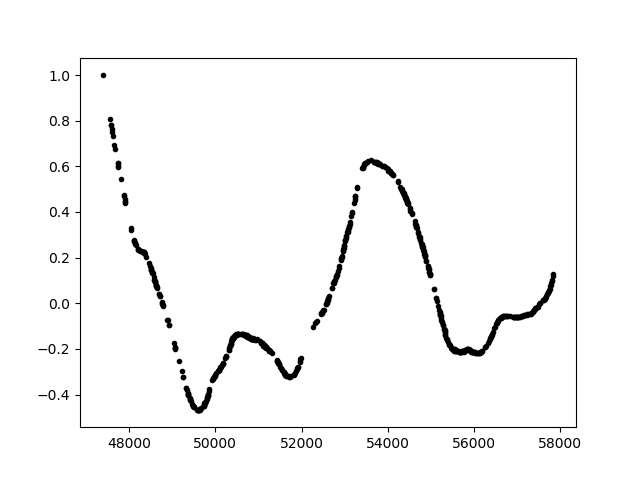

NameError: name 'gp_rbf' is not defined

In [5]:
plt.figure()
plt.plot(data[1],data_test, 'k.')
plt.errorbar(data[1], data_test, sigma_test, c='k', linestyle='None')
plt.plot(data[0], gp_rbf[0], c='r')
plt.fill_between(data[0], gp_rbf[0]+gp_rbf[1]*2, gp_rbf[0]-gp_rbf[1]*2, color='r', alpha=0.2)
#plt.plot(data[0], gp_per[0], c='b')
#plt.fill_between(data[0], gp_per[0]+gp_per[1]*2, gp_per[0]-gp_per[1]*2, color='b', alpha=0.2)

In [4]:
data = (B0105[1::2,0],B0105[::2,0],B0105[::2,1],B0105[1::2,1],B0105[1::2,2],B0105[::2,2])

Nens = 100   # number of ensemble points
Nburnin = 500   # number of burn-in samples
Nsamples = 500  # number of final posterior samples

## RBF

In [10]:
ndims_rbf = 2    # Number of dimensions
ndims_per = 3
inisamples_rbf = np.vstack((gamma.rvs(5.5, size=Nens),gamma.rvs(4.5, loc=150, size=Nens))).T
inisamples_per = np.vstack((gamma.rvs(5.5, size=Nens),
                        gamma.rvs(4.5, loc=150, size=Nens), uniform.rvs(np.pi, 100*np.pi, size=Nens))).T

# set additional args for the posterior (the data, the noise std. dev., and the abscissa)
argslist = (data, local_periodic_logprior, local_periodic)

# set up the sampler
sampler = em.EnsembleSampler(Nens, ndims_per, logposterior, args=argslist)

In [28]:
# pass the initial samples and total number of samples required
t0 = time.time() # start time
sampler.run_mcmc(inisamples_per, Nsamples+Nburnin, progress=True);
t1 = time.time()

timeemcee = (t1-t0)
print("Time taken to run 'emcee' is {} seconds".format(timeemcee))

# extract the samples (removing the burn-in)
samples_emcee = sampler.chain[:, Nburnin:, :].reshape((-1, ndims_rbf))

/home/jacob/anaconda3/envs/pulsar_timing/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in sqrt
100%|██████████| 1000/1000 [1:16:53<00:00,  4.61s/it]

Time taken to run 'emcee' is 4618.070034265518 seconds


Number of independent samples is 8400


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

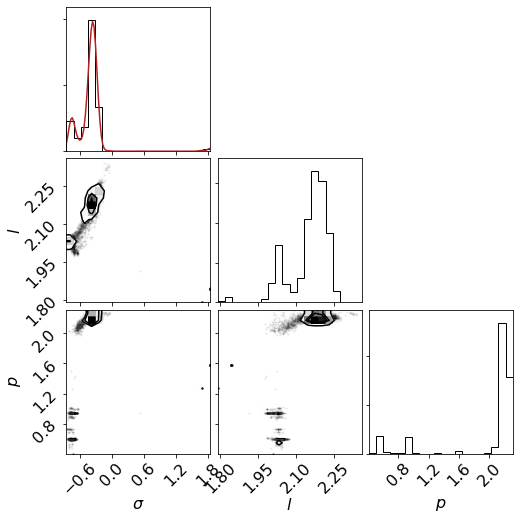

In [5]:
#np.save('B0105/local_periodic.npy', samples_emcee)

samples_rbf = np.load('HPC_Results/B0105+64Local_Periodic.npy')

import matplotlib as mpl
import corner
from scipy.stats import gaussian_kde
# plot the resulting posteriors
mpl.rcParams.update({'font.size': 16})

#def plotposts(samples, truths=[m,c]):
def plotposts(samples, **kwargs):
    """
    Function to plot posteriors using corner.py and scipy's gaussian KDE function.
    """
    
    fig = corner.corner(samples, labels=[r'$\sigma$', r'$l$', r'$p$'], hist_kwargs={'density': True}, **kwargs)

    # plot KDE smoothed version of distributions
    for axidx, samps in zip([0, 3], samples.T):
        kde = gaussian_kde(samps)
        xvals = fig.axes[axidx].get_xlim()
        xvals = np.linspace(xvals[0], xvals[1], 100)
        fig.axes[axidx].plot(xvals, kde(xvals), color='firebrick')

#s_acl, l_acl= sampler.get_autocorr_time(c=1, quiet=True)
#print("The autocorrelation length for s is {0} and l is {1}".format(s_acl, l_acl))

# thin out the chain
#samples_emcee = sampler.chain[:, Nburnin::int(max([s_acl, l_acl])), :].reshape((-1, ndims_rbf))
print("Number of independent samples is {}".format(len(samples_rbf)))

# plot the resulting posteriors
plotposts(samples_rbf)

from IPython.display import display, Math

labels = ['s', 'l', 'p']

for i in range(3):
    mcmc = np.percentile(samples_rbf[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

# Z convergence test

In [58]:
n = 1000
r = uniform.rvs(size=(n, 2))
theta_samples_rbf = np.array([gamma.ppf(r[:,0], 5.5), gamma.ppf(r[:,1], 4.5, loc=150)]).T
def func(n):
    
    global r, theta_samples_rbf
    z_tmp = np.exp(loglikelihood(theta_samples_rbf[n], data)-1500)
    z_sq_tmp = np.exp(2*loglikelihood(theta_samples_rbf[n], data)-3000)
    
    return np.array([z_tmp, z_sq_tmp, n+1])

if __name__ == '__main__':
    p = Pool(2)
    r = p.map(func, tqdm(range(n)))
    p.close()
    p.join()

100%|██████████| 1000/1000 [00:00<00:00, 166871.06it/s]/home/jacob/anaconda3/envs/pulsar_timing/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in sqrt
/home/jacob/anaconda3/envs/pulsar_timing/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in sqrt



In [66]:
n = 1000
u = uniform.rvs(size=(n,2))
theta_samples_rbf = np.vstack((gamma.ppf(u[:,0], 5.5), gamma.ppf(u[:,1], 4.5, loc=150))).T

likelihood_vals = np.ones((3,n))

for i in tqdm(range(n)):

    likelihood_vals[0,i] = np.exp(loglikelihood(theta_samples_rbf[i], data)-1500)
    likelihood_vals[1,i] = np.exp(2*loglikelihood(theta_samples_rbf[i], data)-3000)
    if likelihood_vals[0,i] == np.inf:
        print('Inf...')
        break
    
N = np.cumsum(likelihood_vals[2])
Z = 1/N * np.cumsum(likelihood_vals[0])
Z_sq = 1/N * np.cumsum(likelihood_vals[1])

100%|██████████| 1000/1000 [01:34<00:00, 10.63it/s]


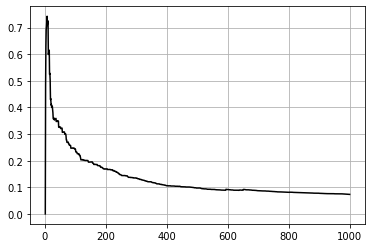

In [68]:
fig1, ax1 = plt.subplots()
ax1.plot(N, np.sqrt((Z_sq-Z**2)/(N*Z**2)), c='k')
ax1.grid(True)

# Z estimate - RBF

In [5]:
n = 1000
theta_samples_rbf = rbf_samples(n, data)

loglikelihood_vals = np.zeros(n)
likelihood_vals = np.zeros((2,n))

for i in tqdm(range(n)):
    
    loglikelihood_vals[i] = loglikelihood(theta_samples_rbf[i], data)
    likelihood_vals[0,i] = np.exp(loglikelihood(theta_samples_rbf[i], data)-1500)
    likelihood_vals[1,i] = np.exp(2*loglikelihood(theta_samples_rbf[i], data)-3000)
    if likelihood_vals[0,i] == np.inf:
        print('Inf...')
        print(loglikelihood(theta_samples_rbf[i], data))
        break
    

Z = 1/n*np.sum(likelihood_vals[0])
Z_sq = 1/n*np.sum(likelihood_vals[1])

Z_err, i = round_sig(np.sqrt(Z_sq-Z**2)/(np.sqrt(n)*Z))
Z_val = np.around(np.log(Z)+1500, i)

print('Log evidence estimate using direct sampling from the prior for RBF kernel: %s +- %s' %(Z_val, Z_err))

100%|██████████| 1000/1000 [03:24<00:00,  4.89it/s]

Log evidence estimate using direct sampling from the prior for RBF kernel: 1819.5 +- 0.7


# Z estimate - Local Periodic

In [7]:
n = 1000
theta_samples_per = local_periodic_samples(n, data)

likelihood_vals = np.zeros((2,n))

for i in tqdm(range(n)):

    likelihood_vals[0,i] = np.exp(loglikelihood(theta_samples_per[i], data, kernel=local_periodic)-1500)
    likelihood_vals[1,i] = np.exp(2*loglikelihood(theta_samples_per[i], data, kernel=local_periodic)-3000)
    if likelihood_vals[0,i] == np.inf:
        print('Inf...')
        break
    

Z = 1/n*np.sum(likelihood_vals[0])
Z_sq = 1/n*np.sum(likelihood_vals[1])

Z_err, i = round_sig(np.sqrt(Z_sq-Z**2)/(np.sqrt(n)*Z))
Z_val = np.around(np.log(Z)+1500, i)

print('Log evidence estimate using direct sampling from the prior for Local Periodic kernel: %s +- %s'
      %(Z_val, Z_err))

100%|██████████| 1000/1000 [03:16<00:00,  5.10it/s]

Log evidence estimate using direct sampling from the prior for Local Periodic kernel: 1827.9 +- 1.0


# Z estimate - Matern

In [28]:
n = 1000
theta_samples_rbf = matern_samples(n, data)

likelihood_vals = np.zeros((2,n))

for i in tqdm(range(n)):

    likelihood_vals[0,i] = np.exp(loglikelihood(theta_samples_rbf[i], data, kernel=matern)-1500)
    likelihood_vals[1,i] = np.exp(2*loglikelihood(theta_samples_rbf[i], data, kernel=matern)-3000)
    if likelihood_vals[0,i] == np.inf:
        print('Inf...')
        break
    

Z = 1/n*np.sum(likelihood_vals[0])
Z_sq = 1/n*np.sum(likelihood_vals[1])

Z_err, i = round_sig(np.sqrt(Z_sq-Z**2)/(np.sqrt(n)*Z))
Z_val = np.around(np.log(Z)+1500, i)

print('Log evidence estimate using direct sampling from the prior for RBF kernel: %s +- %s'
      %(Z_val, Z_err))

100%|██████████| 1000/1000 [08:53<00:00,  1.88it/s]

Log evidence estimate using direct sampling from the prior for RBF kernel: 1840.3 +- 1.0


# Comparison

In [29]:
Z_rbf = 1819.5
Z_per = 1827.9
Z_mat = 1840.3
Z_rbf_sigma = 0.7
Z_per_sigma = 1
Z_mat_sigma = 1

K_per_rbf = 1/np.log(10) * (Z_per-Z_rbf)
K_mat_per = 1/np.log(10) * (Z_mat-Z_per)
K_mat_rbf = 1/np.log(10) * (Z_mat-Z_rbf)

K_per_rbf_sigma = 1/np.log(10) * np.sqrt(Z_per_sigma**2 + Z_rbf_sigma**2)
K_mat_per_sigma = 1/np.log(10) * np.sqrt(Z_per_sigma**2 + Z_mat_sigma**2)
K_mat_rbf_sigma = 1/np.log(10) * np.sqrt(Z_rbf_sigma**2 + Z_mat_sigma**2)

print(f'Log10 Bayes factor between Local Periodic and RBF kernels is {K_per_rbf:1.2} +- {K_per_rbf_sigma:.1f}')
print(f'Log10 Bayes factor between Matern and Local Periodic kernels is {K_mat_per:1.2} +- {K_mat_per_sigma:.1f}')
print(f'Log10 Bayes factor between Matern and RBF kernels is {K_mat_rbf:1.3} +- {K_mat_rbf_sigma:.2f}')

Log10 Bayes factor between Local Periodic and RBF kernels is 3.6 +- 0.5
Log10 Bayes factor between Matern and Local Periodic kernels is 5.4 +- 0.6
Log10 Bayes factor between Matern and RBF kernels is 9.03 +- 0.53


# Matern Kernel - Approx. time bb

In [92]:
def matern(theta, x):

    u = np.sqrt(2 * theta[1]) * abs(np.subtract.outer(x,x) / theta[2])
    u[u == 0.0] += np.finfo(float).eps
    K = theta[0] * 2**(1-theta[1]) / gamma_func(theta[1]) * (u)**theta[1] * kv(theta[1], u)
    
    return K

d = np.arange(0, 200, 5)
theta_rbf = np.array([1,1], dtype='float64')
theta_m = np.array([1, 1, 1], dtype='float64')

In [93]:
nu = np.linspace(0,18, 1000)
res = np.zeros((len(nu)-1,len(d)))


for i in tqdm(range(len(nu)-1)):
    
    mi = matern([1,nu[i],1], d)[0]
    mj = matern([1,nu[i+1],1], d)[0]
    
    res[i] = mi/mj

 34%|███▍      | 340/999 [00:00<00:00, 660.77it/s]/home/jacob/anaconda3/envs/pulsar_timing/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/jacob/anaconda3/envs/pulsar_timing/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 999/999 [00:01<00:00, 654.48it/s]


<IPython.core.display.Javascript object>


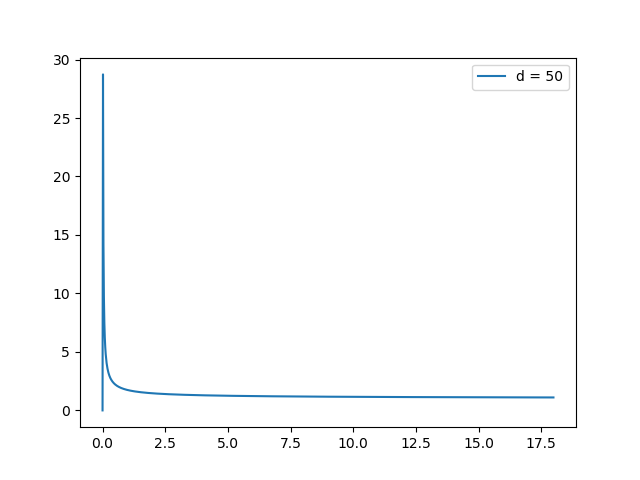

1.1072802125616905


In [96]:
plt.figure()
#for i in range(1):
#    plt.plot(nu[:-1],res[:,i])
i = -0
plt.plot(nu[:-1], res[:,i], label=f'd = {d[i]:.0f}')
plt.legend()
print(res[-1,i])

## Prior tests... again

In [18]:
class uniform_log_gen(rv_continuous):
    def _pdf(self, x, a, b):
        return uniform.pdf(10**x, a, b) * 10**x * np.log(10)
    
    def _cdf(self, x, a, b):
        return uniform.cdf(10**x, a, b)

class gamma_log_gen(rv_continuous):
    def _pdf(self, x, a, b):
        return gamma.pdf(10**x, a, b) * 10**x * np.log(10)
    
    def _cdf(self, x, a, b):
        return gamma.cdf(10**x, a, b)
    
class uniform_ln_gen(rv_continuous):
    def _pdf(self, x, a, b):
        return uniform.pdf(np.exp(x), a, b) * np.exp(x)
    
    def _cdf(self, x, a, b):
        return uniform.cdf(np.exp(x), a, b)

In [19]:
uniform_log = uniform_log_gen(name='uniform_log')
uniform_ln = uniform_ln_gen(name='uniform_ln')
gamma_log = gamma_log_gen(name='gamma_log')

In [52]:
a, b = -2, 2
xmin = uniform.ppf(0.0001, a, b-a)
xmax = uniform.ppf(0.9999, a, b-a)
x = np.linspace(xmin, xmax, 1000)
y = uniform.pdf(x, a, b-a)

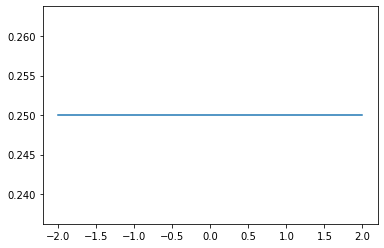

In [53]:
plt.figure()
plt.plot(x,y)

In [29]:
display(uniform.cdf(20,0.01,100.01)-uniform.cdf(10,0.01,100.01))
display(uniform.cdf(30,0.01,100.01)-uniform.cdf(20,0.01,100.01))

0.09999000099989999

0.09999000099989999